## Содержание:
* [Знакомство с Pandas](#pandas)
* [Графическое представление и описание поведения временного ряда](#first_first-bullet)
   * [Выделение закономерных (неслучайных) составляющих временного ряда](#second-bullet)
   * [Стационарность](#stacionary)
   * [Тренд](#trend)
   * [Выбросы](#out)
   * [Сезонность](#season)
* [Сглаживание и фильтрация](#filtre)
* [Автокорреляция и коррелограмма](#autocor)

### Знакомство с Pandas <a class="anchor" id="pandas"></a>

Встречайте библиотеку, которая позволяет комфортно обрабатывать и анализировать данные - Pandas!

In [ ]:
!pip install pandas
!pip install statsmodels

In [2]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd

Мы будем работать с двумя рядами - нефильтрованной записью ЭКГ и записями о пассажиропотоке.

Импортируем необходимые данные

In [3]:
dirname = os.path.abspath(os.curdir) + r'\data'

temp = pd.read_csv(path.join(os.sep, dirname, 'Offset equipment temperature degrees Celsius observed every 10 minutes.csv'), index_col = 0)

In [5]:
temp["temperature"] = temp["temperature"].fillna(temp["temperature"].mean())
temp.head()

,temperature
1,22.0
2,22.8
3,22.9
4,22.5
5,22.5


In [6]:
temp.describe()

,temperature
count,4325.000000
mean,29.225526
std,5.326126
min,19.000000
25%,24.600000
50%,29.500000
75%,34.000000
max,39.500000


### Графическое представление и описание поведения временного ряда <a class="anchor" id="first_first-bullet"></a>


In [7]:
def plot_assignation(axp, data, xlabel, ylabel, title1):
    axp.plot(data)
    axp.set_xlabel(xlabel)
    axp.set_ylabel(ylabel)
    axp.set_title(title1 )

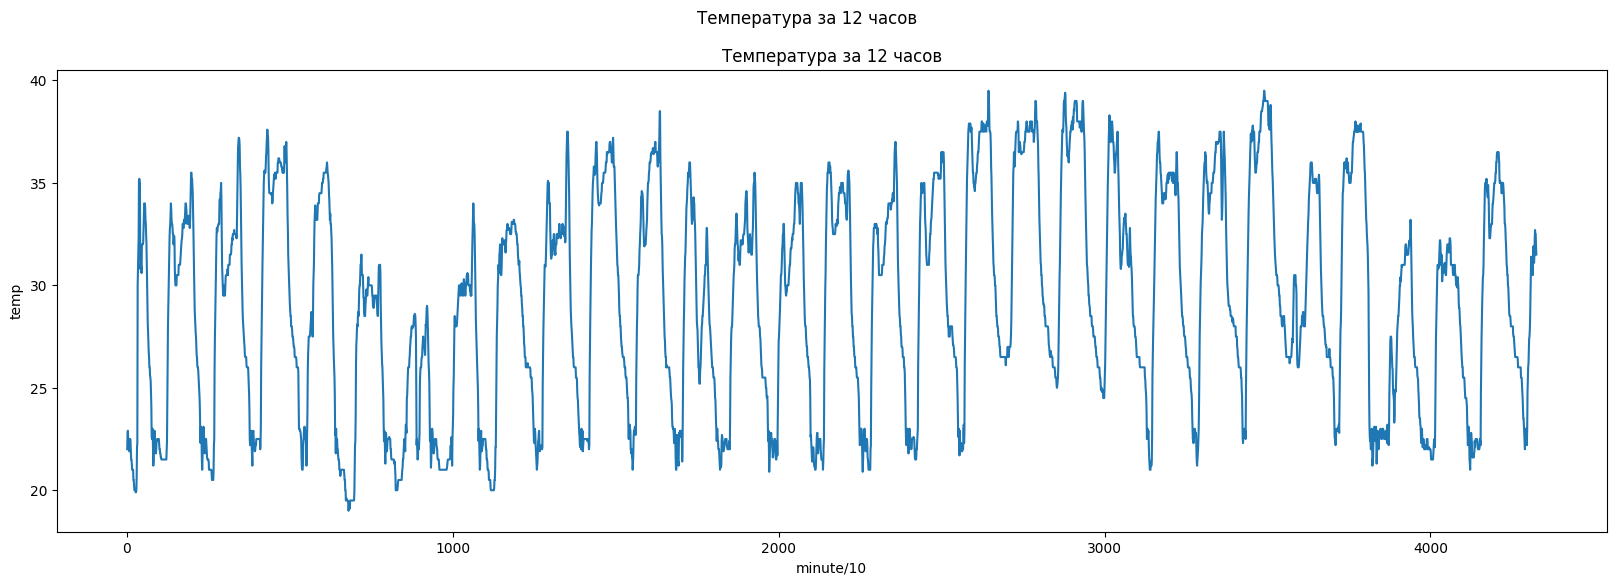

In [13]:
fig, axs = plt.subplots(1,1,figsize=(20, 6))
fig.suptitle('Температура за 12 часов')

plot_assignation(axs, temp["temperature"], 'minute/10', 'temp','Температура за 12 часов')

### Выделение закономерных (неслучайных) составляющих временного ряда <a class="anchor" id="second-bullet"></a>

#### Разложения ряда на компоненты

Тренды, Сезонность, Остаточность


https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html


1) ***Тренд*** — общая долгосрочная тенденция изменения временного ряда, лежащая в основе его динамики.

2) ***Сезонная вариация*** — краткосрочное регулярно повторяющееся колебание значений временного ряда вокруг тренда.

3) ***Циклические колебания*** характеризуют так называемый цикл деловой активности, или экономический цикл, состоящий из экономического подъема, спада, депрессии и оживления. Этот цикл повторяется регулярно.

4) ***Остаточная вариация***, которая может быть двух видов:
**аномальная вариация** — неестественно большое отклонение временного ряда, которое оказывает воздействие на единичное наблюдение;
**случайная вариация** — малое отклонение, которое невозможно предвидеть. В долгосрочной перспективе случайные вариации могут с равной вероятностью как снизить, так и увеличить объем продаж.

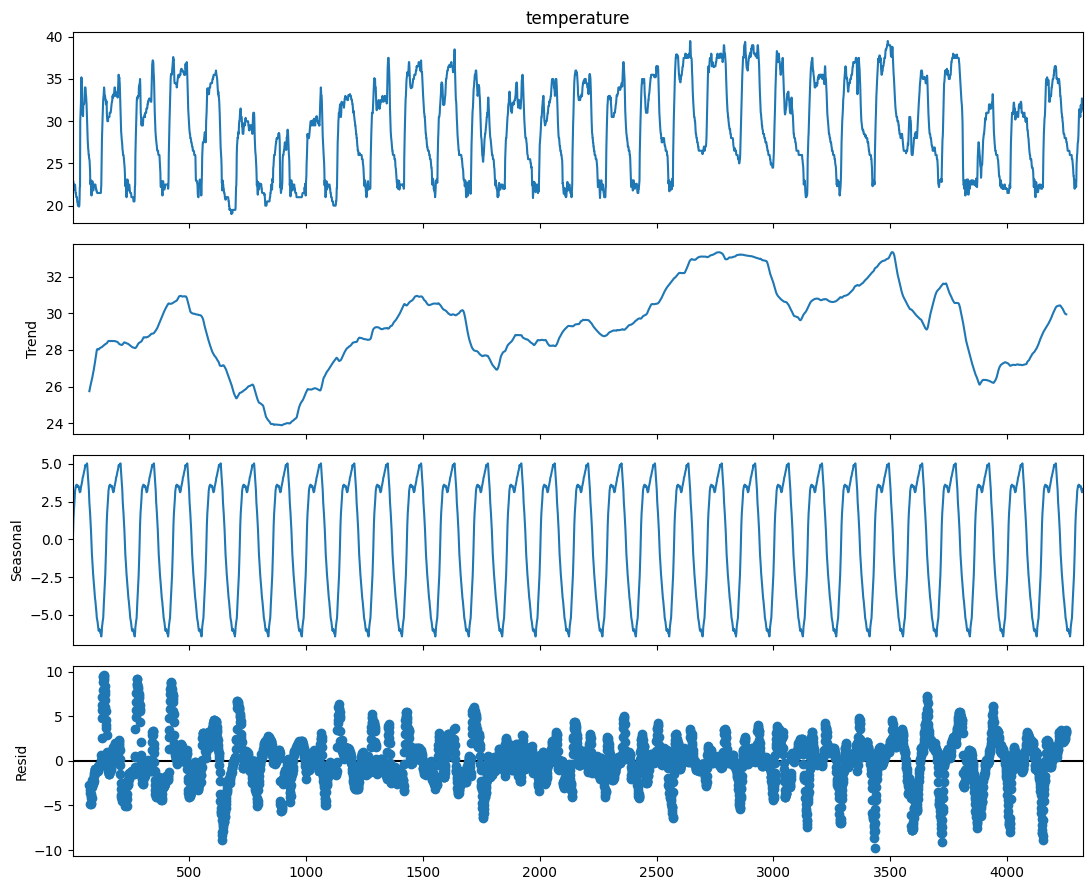

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9


decompose = seasonal_decompose(temp["temperature"], period=143)
decompose.plot()
plt.show()

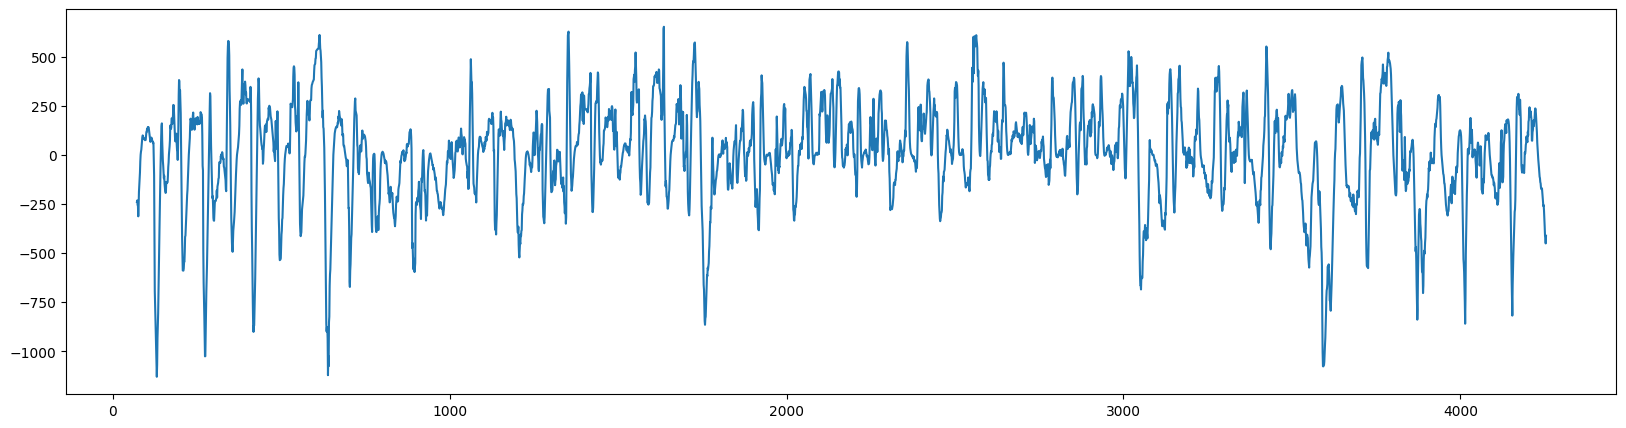

In [19]:
new_ps = decompose.trend*(decompose.seasonal+1)*decompose.resid

fig, axs = plt.subplots(figsize=(20, 5))
 
plt.plot(new_ps)
plt.show()

<Axes: >

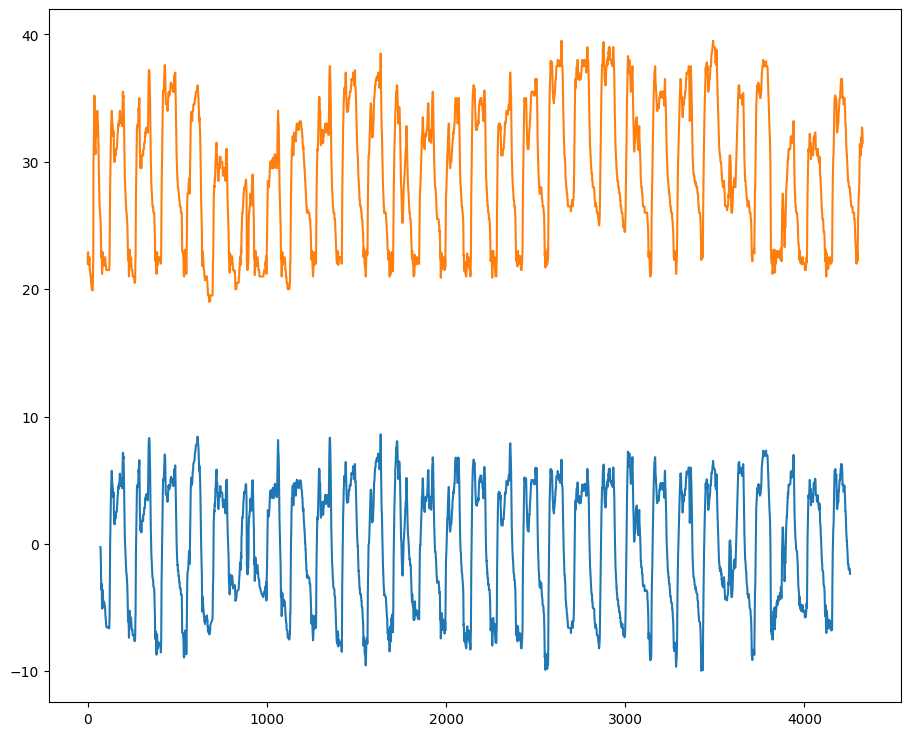

In [20]:
temp_r = temp["temperature"] - decompose.trend

temp_r.plot()
temp["temperature"].plot()

## Стационарный процесс  <a class="anchor" id="stacionary"></a>


Стационарный процесс - это случайный процесс, безусловное совместное распределение вероятностей которого не изменяется при сдвиге во времени. Следовательно, такие параметры, как среднее значение и дисперсия, также не меняются со временем, поэтому стационарные временные ряды легче прогнозировать.

Есть несколько способов установить, является ли временной ряд стационарным или нет, наиболее распространенными являются старая добрая визуализация, просмотр автокорреляции и выполнение статистических тестов.

Наиболее распространенным тестом является тест Дики-Фуллера (также называемый тест ADF), где нулевая гипотеза состоит в том, что временной ряд имеет единичный корень, другими словами, временной ряд не является стационарным.

Мы проверим, можно ли отвергнуть нулевую гипотезу, сравнив значение p с выбранным порогом (α), чтобы, если значение p меньше, мы могли отклонить нулевую гипотезу и предположить, что временной ряд с уверенностью является стационарным. уровень 1-α (технически мы просто не можем сказать, что это не так)

Временной ряд имеет единичный корень, или порядок интеграции один, если его первые разности образуют стационарный ряд. Это условие записывается как
$y_t\thicksim I(1)$ если ряд первых разностей $\triangle y_t=y_t-y_{t-1}$ является стационарным $\triangle y_t\thicksim I(0)$.

При помощи этого теста проверяют значение коэффициента $a$ в  авторегрессионном уравнении первого порядка AR(1)
$y_t=a\cdot y_{t-1}+\varepsilon_t,$
где $y_t$ — временной ряд, а $\varepsilon$— ошибка.

Если $a=1$, то процесс имеет единичный корень, в этом случае ряд $y_t$ не стационарен, является интегрированным временным рядом первого порядка $I(1)$. Если $|a|<1$, то ряд стационарный $I(0)$.


In [21]:
# импортируем функцию, описывающую тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

In [23]:
alpha = 0.05
name = "Температура"
ts = temp["temperature"]

print(f'Тест Дики-Фуллера ряда {name} :')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Температура :


Test Statistic                -8.887923e+00
p-value                        1.265350e-14
#Lags Used                     1.300000e+01
Number of Observations Used    4.311000e+03
Critical Value (1%)           -3.431868e+00
Critical Value (5%)           -2.862211e+00
Critical Value (10%)          -2.567127e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


### Тренд <a class="anchor" id="trend"></a>

Тренд - это компонент временного ряда, который представляет низкочастотные колебания во временном ряду, при этом высокочастотные и среднечастотные колебания отфильтрованы.

Как известно из лекции, существует три основных типа трендов.
1. Первым и самим очевидным типом тренда представляется тренд среднего, когда временной
ряд выглядит как колебания около медленно возрастающей или убывающей величины.

1. Второй тип трендов – это тренд дисперсии. В этом случае во времени меняется амплитуда
колебаний переменной.

1. Третий и более тонкий тип тренда, визуально не всегда наблюдаемый, – изменение
величины корреляции между текущим и предшествующим значениями ряда, т. е. тренд
автоковариации и автокорреляции.

Давайте напишем функцию, которая поможет нам понять тенденцию и движения временного ряда. Мы хотим видеть на графике некоторую скользящую статистику, такую как:

M скользящее среднее: невзвешенное среднее предыдущих n данных (также называемое скользящим средним).

Полосы Боллинджера: верхняя полоса в k раз на n-периодное стандартное отклонение выше скользящей средней и нижняя полоса в k раз на стандартное отклонение N ниже.

C:\Users\vegam\AppData\Local\Temp\ipykernel_10336\1110318620.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


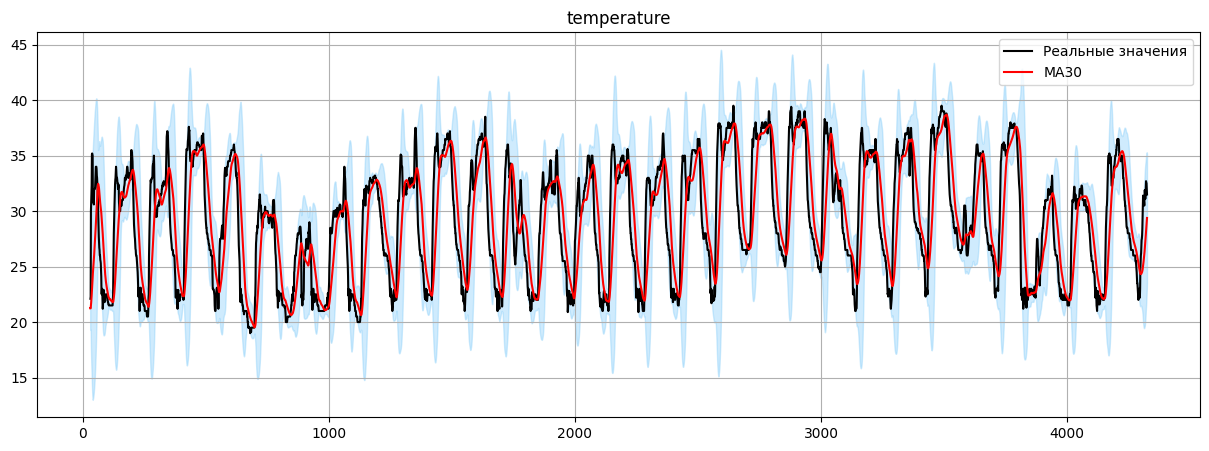

In [24]:
# указываем размер окна
window = 30

# вычисляем скользящее среднее и стандартное отклонение
rolling_mean = ts.rolling(window=window).mean()
rolling_std = ts.rolling(window=window).std()

plt.figure(figsize=(15,5))
plt.title(ts.name)
plt.plot(ts[window:], label='Реальные значения', color="black")

# отрисовываем скользящее среднее
plt.plot(rolling_mean, 'g', label='MA'+str(window),
             color="red")

# отрисовываем верхний и нижний интервалы
lower_bound = rolling_mean - (1.96 * rolling_std)
upper_bound = rolling_mean + (1.96 * rolling_std)

plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                 color='lightskyblue', alpha=0.4)
plt.legend(loc='best')
# показываем сетку на графике
plt.grid(True)
plt.show()


### Сезонность  <a class="anchor" id="season"></a>

Существует несколько подходов к анализу структуры временных рядов, содержащих сезонные или циклические колебания. Простейший подход – расчет значений сезонной компоненты методом скользящей средней и построение аддитивной или мультипликативной модели временного ряда.

Выбор аддитивной или мультипликативной модели проводится на основе анализа структуры сезонных колебани. Если амплитуда колебаний приблизительно постоянна, строят аддитивную модель временного ряда, в которой
значения сезонной компоненты предполагаются постоянными для различных циклов.

Если амплитуда сезонных колебаний возрастает или уменьшается, строят мультипликативную модель
временного ряда, которая ставит уровни ряда в зависимость от значений сезонной компоненты.

Построение аддитивной и мультипликативной моделей сводится к расчету значений $T$, $S$ и $E$ для
каждого уровня ряда.


### Автокорреляция и коррелограмма <a class="anchor" id="autocor"></a>



In [25]:
import statsmodels.tsa.api as smt

<Figure size 1200x700 with 0 Axes>

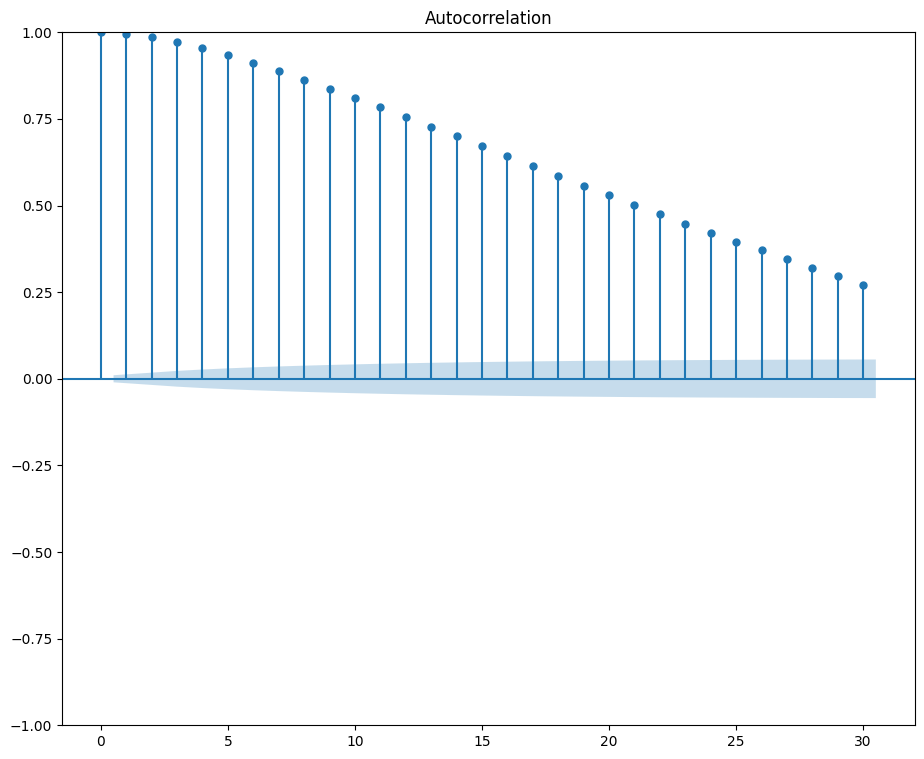

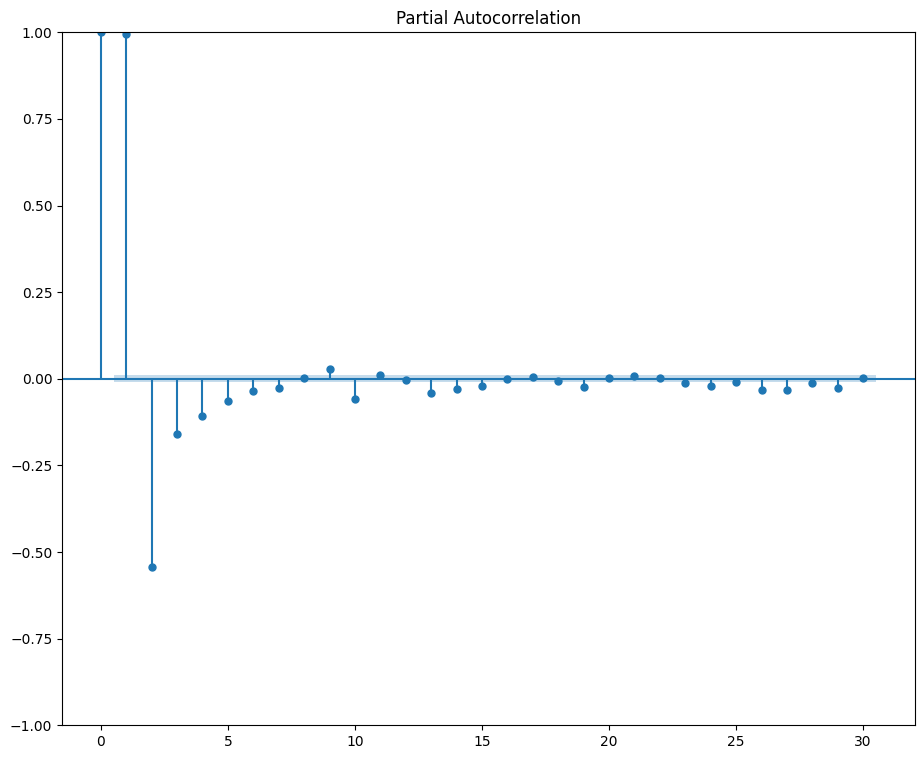

In [26]:
ts = temp["temperature"]


fig = plt.figure(figsize=(12, 7))
# рисуем автокорреляционную функцию
# 
# изображение отрисовывается с запаздываниями по горизонтали и корреляциями по
# вертикали
ac_plot = smt.graphics.plot_acf(ts, lags=30, alpha=0.5)

# есть также функция отрисовки частичной автокорреляции
pac_plot = smt.graphics.plot_pacf(ts, lags=30, alpha=0.5)

# Частичная автокорреляция (Partial Autocorrelation) — это краткая
# характеристика взаимосвязи между наблюдением во временном ряду и наблюдениями
# на предыдущем отрезке времени, когда влияние малой задержки устранено.
# Автокорреляция состоит как из прямой, так и из косвенной корреляции.

Можно все эти графики красиво отрисовать

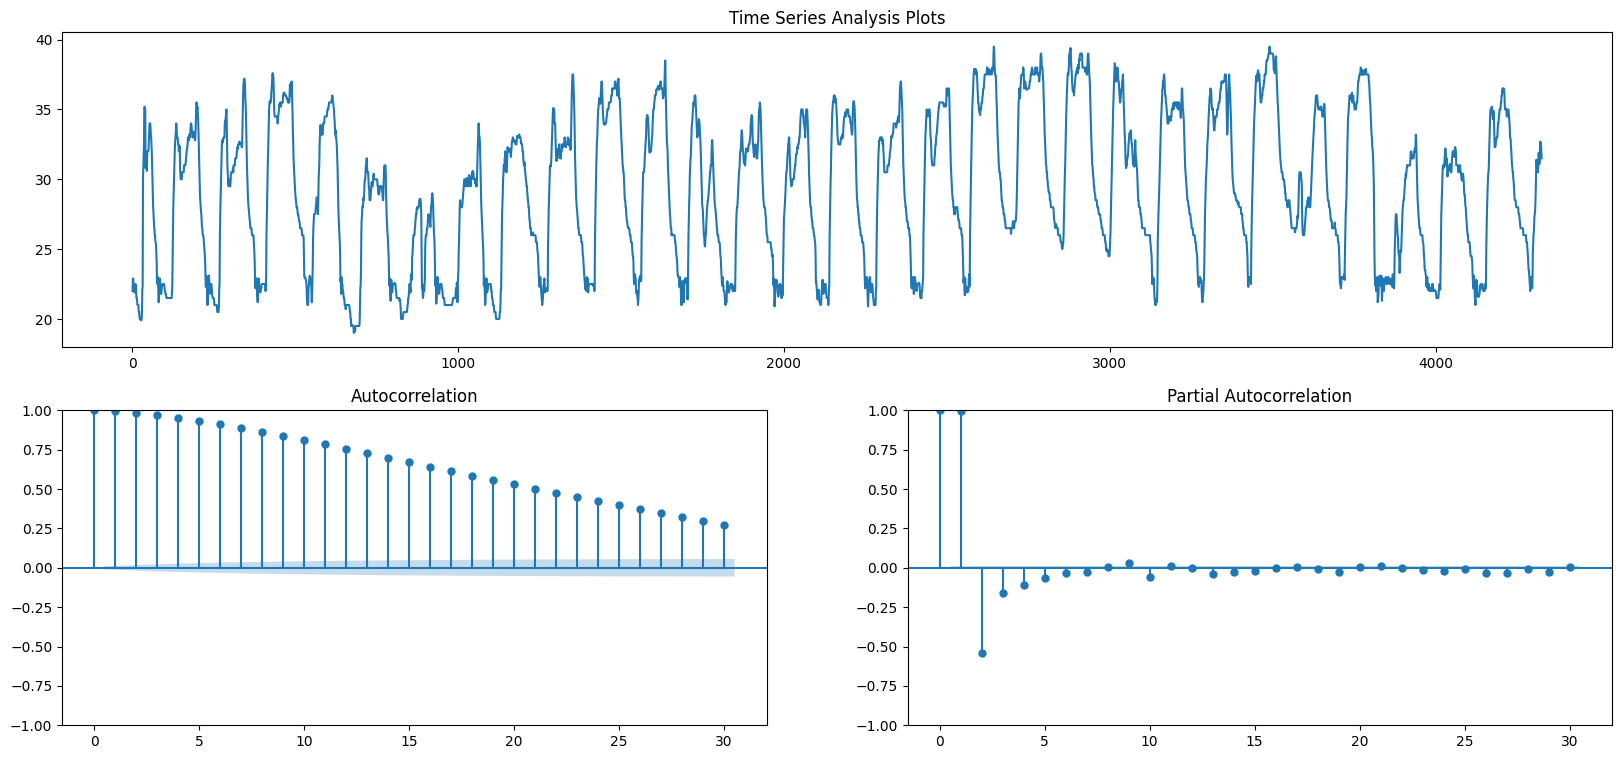

In [27]:
fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=30, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=30, ax=pacf_ax, alpha=0.5)
None